# Assignment 2

Group 6 - Brook Bunting, Garrett Moore, and Mohit Vaghela 

Part 1:

In [44]:
import pandas as pd
import numpy as np
import yfinance as yf
from yahoofinancials import YahooFinancials
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
figsize(20, 5)
import csv    
import seaborn as seabornInstance 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy.stats import norm
from scipy import stats

In [45]:
#i. Download monthly price data of S&P500 and a Netflix's stock for the period 01/01/2004 to 12/31/2019 

In [46]:
Netflix = YahooFinancials('NFLX')
SP500 = YahooFinancials('^GSPC')
assets = ['^GSPC', 'NFLX']

yahoo_financials = YahooFinancials(assets)

data = yahoo_financials.get_historical_price_data(start_date='2004-01-01', 
                                                  end_date='2019-12-31', 
                                                  time_interval='monthly')

In [47]:
prices_df = pd.DataFrame({
    a: {x['formatted_date']: x['adjclose'] for x in data[a]['prices']} for a in assets})

In [48]:
prices_df.head()

,^GSPC,NFLX
2004-01-01,1131.130005,5.243571
2004-02-01,1144.939941,4.914286
2004-03-01,1126.209961,4.874286
2004-04-01,1107.300049,3.622857
2004-05-01,1120.680054,4.702857


In [49]:
#ii.Compute the monthly returns for the S&P 500 and the stock. Construct one data frame to store the return series. 

In [50]:
for i in prices_df.columns:
    prices_df['{} log_return'.format(i)]= np.log(prices_df[i]/prices_df[i].shift(1))

In [51]:
prices_df.head()

,^GSPC,NFLX,^GSPC log_return,NFLX log_return
2004-01-01,1131.130005,5.243571,NaN,NaN
2004-02-01,1144.939941,4.914286,0.012135,-0.064856
2004-03-01,1126.209961,4.874286,-0.016494,-0.008173
2004-04-01,1107.300049,3.622857,-0.016933,-0.296711
2004-05-01,1120.680054,4.702857,0.012011,0.260907


In [52]:
# Dropping rows will null values
prices_df = prices_df.dropna()

In [53]:
# Constructing returns dataframe
returns_df = prices_df[['^GSPC log_return', 'NFLX log_return']]
returns_df.head()

,^GSPC log_return,NFLX log_return
2004-02-01,0.012135,-0.064856
2004-03-01,-0.016494,-0.008173
2004-04-01,-0.016933,-0.296711
2004-05-01,0.012011,0.260907
2004-06-01,0.017829,0.089439


In [54]:
#iii. Construct summary statistics, histogram, correlation matrix of the return series. 

In [55]:
# Summary stastitics
returns_df.describe()

,^GSPC log_return,NFLX log_return
count,191.000000,191.000000
mean,0.005495,0.021583
std,0.039537,0.162646
min,-0.185636,-0.729854
25%,-0.015415,-0.064978
50%,0.011510,0.030695
75%,0.029414,0.117395
max,0.102307,0.579218


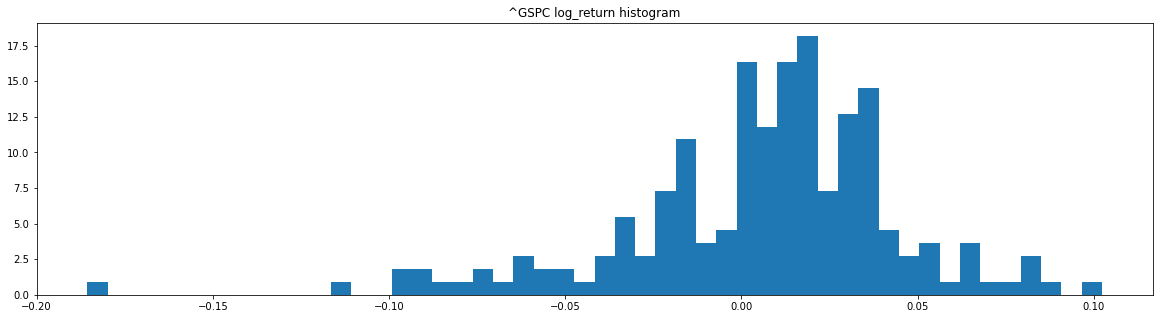

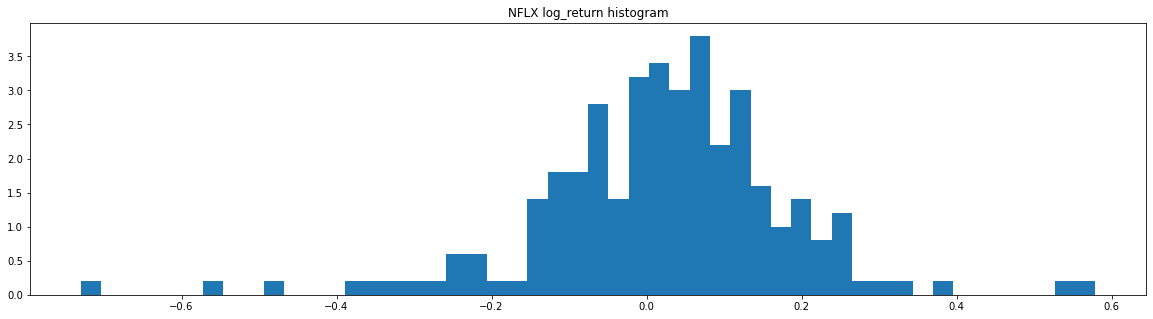

In [56]:
# Histogram of Log returns

for i in returns_df:
    plt.hist(prices_df[i], density=True, bins=50)
    plt.title('{}'.format(i+' histogram'))
    plt.show()

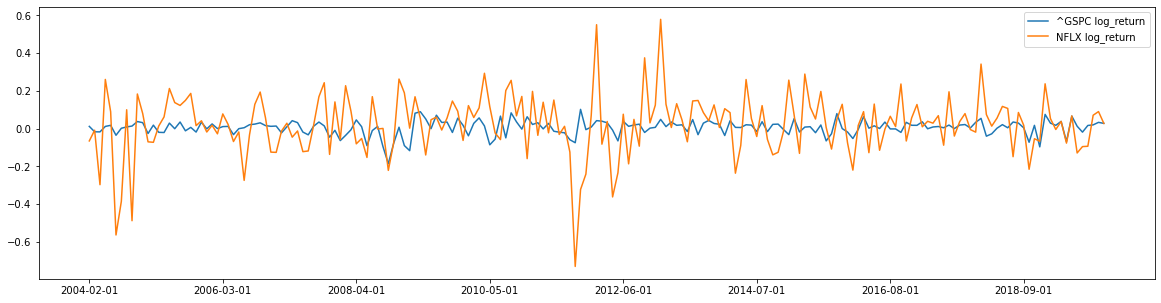

In [57]:
# Time-series comparison
returns_df.plot()

In [58]:
# Correlation of log returns

returns_df.corr()

,^GSPC log_return,NFLX log_return
^GSPC log_return,1.000000,0.257989
NFLX log_return,0.257989,1.000000


In [59]:
#iv. Download 3 month TBill rate from Fred. Consider the TBill data  
#for the same sample period 01/01/2004 to 12/31/2019 

In [60]:
from fredapi import Fred
fred = Fred(api_key='85a51879b4652ee61b992b9102f9afde')

In [61]:
TBill = fred.get_series('TB3MS', observation_start='2004-01-01', observation_end='2019-12-31')
TBill.head()

2004-01-01    0.88
2004-02-01    0.93
2004-03-01    0.94
2004-04-01    0.94
2004-05-01    1.02
dtype: float64

In [62]:
#v.Construct a matrix of return series combining Stock, S&P500, and TBill for the sample period. 

In [63]:
returns_df = returns_df.merge(TBill.to_frame(name = 'TBill'), left_index=True, right_index=True)
returns_df.head()

,^GSPC log_return,NFLX log_return,TBill
2004-02-01,0.012135,-0.064856,0.93
2004-03-01,-0.016494,-0.008173,0.94
2004-04-01,-0.016933,-0.296711,0.94
2004-05-01,0.012011,0.260907,1.02
2004-06-01,0.017829,0.089439,1.27


In [64]:
returns_df.corr()

,^GSPC log_return,NFLX log_return,TBill
^GSPC log_return,1.000000,0.257989,-0.022120
NFLX log_return,0.257989,1.000000,-0.065687
TBill,-0.022120,-0.065687,1.000000


In [65]:
#vi. Find Beta for the stock based on the sample data using CAPM model. 

In [66]:
returns_df['TBill_final'] = returns_df['TBill']/100

In [67]:
returns_df.head()

,^GSPC log_return,NFLX log_return,TBill,TBill_final
2004-02-01,0.012135,-0.064856,0.93,0.0093
2004-03-01,-0.016494,-0.008173,0.94,0.0094
2004-04-01,-0.016933,-0.296711,0.94,0.0094
2004-05-01,0.012011,0.260907,1.02,0.0102
2004-06-01,0.017829,0.089439,1.27,0.0127


In [68]:
# Calculating Excess returns for both stocks
returns_df['excess_market_return'] = returns_df['^GSPC log_return'] - returns_df['TBill_final']
returns_df['excess_NFLX_return'] = returns_df['NFLX log_return'] - returns_df['TBill_final']
returns_df.drop(columns='TBill', inplace=True)

In [69]:
returns_df.head()

,^GSPC log_return,NFLX log_return,TBill_final,excess_market_return,excess_NFLX_return
2004-02-01,0.012135,-0.064856,0.0093,0.002835,-0.074156
2004-03-01,-0.016494,-0.008173,0.0094,-0.025894,-0.017573
2004-04-01,-0.016933,-0.296711,0.0094,-0.026333,-0.306111
2004-05-01,0.012011,0.260907,0.0102,0.001811,0.250707
2004-06-01,0.017829,0.089439,0.0127,0.005129,0.076739


In [70]:
X = returns_df[['excess_market_return']]
y = returns_df[['excess_NFLX_return']]

regressor = LinearRegression()  
regressor.fit(X, y)

print(regressor.intercept_)
print(regressor.coef_)

[0.01710914]
[[1.13581813]]


In [71]:
result = sm.OLS(y,X1)
res = result.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     excess_NFLX_return   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     18.14
Date:                Tue, 13 Oct 2020   Prob (F-statistic):           3.23e-05
Time:                        23:16:11   Log-Likelihood:                 83.061
No. Observations:                 191   AIC:                            -162.1
Df Residuals:                     189   BIC:                            -155.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0171 

In [72]:
kkk = res.summary()
kkk

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     excess_NFLX_return   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     18.14
Date:                Tue, 13 Oct 2020   Prob (F-statistic):           3.23e-05
Time:                        23:16:20   Log-Likelihood:                 83.061
No. Observations:                 191   AIC:                            -162.1
Df Residuals:                     189   BIC:                            -155.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0171      0.012      1.479      0.141      -0.006       0.040
excess_market_return     1.1358      0.267      4.259      0.000       0.610       1.662
==============================================================================
Omnibus:                       28.170   Durbin-Watson:                   1.696
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.519
Skew:                          -0.574   Prob(JB):                     5.40e-18
Kurtosis:                       5.945   Cond. No.                         23.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
#Test the null hypothesis; what do you conclude? Draw your conclusion based on p-value.  

In [74]:
stats.ttest_1samp(returns_df['excess_market_return'],0)

Ttest_1sampResult(statistic=-2.4242421952478574, pvalue=0.016276835611399573)

The p-value is less than 0.05, therefore we reject the null hypothesis. 

In [75]:
#Estimate Beta1 numerically using the sample period data. Obtain beta of the stock from available stock report.  
#Discuss why these three measures are same or different.

In [76]:
# Beta = Cov(NFLX, SP500)/Variance of Market

# Variance of Market = (std of ^GSPC log_return)^2

In [77]:
returns_df.loc[:,['NFLX log_return','^GSPC log_return']].cov()

,NFLX log_return,^GSPC log_return
NFLX log_return,0.026454,0.001659
^GSPC log_return,0.001659,0.001563


In [78]:
returns_df['^GSPC log_return'].std()

0.039537343401334385

In [79]:
# Cov(NFLX, SP500) = 0.001659
# std of ^GSPC log_return = 0.039537

In [80]:
beta_num = 0.001659/(0.039537**2)
beta_num

1.0613019461554387

Beta by Linear Regression model = 1.13581813

Beta by OLs = 1.0675

Beta numerically = 1.061

Beta on Yahoo Finance = 0.95

The reason the Beta we calculated differ from the Beta provided from Yahoo Finance has to do with the time period. Our data goes back 15 years monthly, while the Yahoo Finance Beta is calculated from 5 year monthly.

In [81]:
#ix. Provide interpretation of the coefficient estimate Beta1  

The coefficient estimated Beta1 we calculated was 1.0613019461554387. This number shows how volatile Netflix is moving compared to the market. Since it is a 1.06, that means that Netflix moves very similar to the way the market moves, and that it moves about 0.06 more than the market in terms of volatility. 

Comparing our Beta to the one provided by yahoo finance, you can see that over the course of the last 5 years compared to the 15 year time frame we used, Netflix Beta has reduces to 0.95 . Which means that it has become more stable than the market, and moves slower then the market.

In [82]:
#x. Comment on model accuracy: standard error and R-square

R-Square = 0.080
Adjusted R-Square = 0.075

The relationship between the market returns and Netflix's returns is .08, which shows a weaker relationship. As standard errorr is .263, we can conclude that our model fits the data. 

In [83]:
#xi. Provide the scatter plot and the fitted line for the linear regression model.   

In [84]:
y_pred = regressor.predict(X)

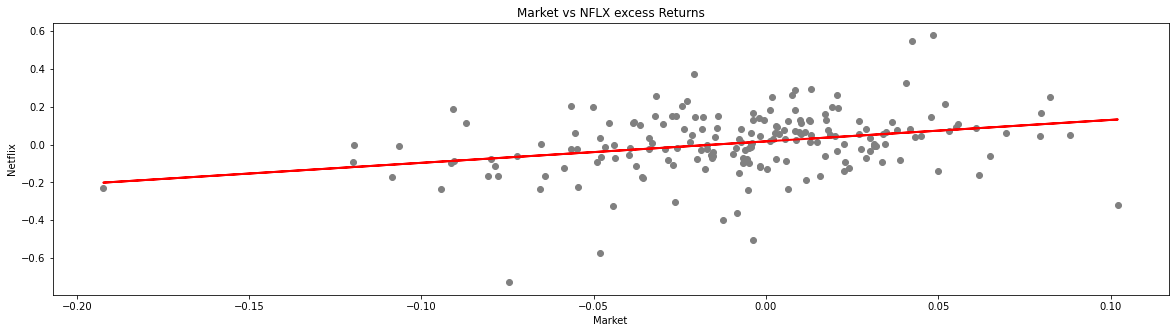

In [85]:
plt.scatter(X, y,  color='gray')
plt.plot(X, y_pred, color='red', linewidth=2)

plt.title("Market vs NFLX excess Returns")
plt.xlabel("Market")
plt.ylabel("Netflix")

plt.show()

In [86]:
#Discuss alpha as estimated by the fitted model.

alpha = 0.01710914

Alpha is the expected return of the portfolio when the benchmark's return equals the risk-free rate. So in our scenario, if the markets return equals the risk free rate, then NTFLX will have expected returns of 1.7%

Part 2:

In [87]:
#Use the Credit data to perform the following tests using Linear Regression settings:

In [88]:
##i. Observe the dimension of the Credit data.

In [89]:
credit = pd.read_csv('Credit.csv')
c2=credit.drop(credit.columns[0], axis=1)

In [90]:
c2.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [91]:
c2.shape

(400, 11)

In [92]:
##ii. Provide a summary stat for the variables in Credit data.

In [93]:
c2.describe()

,Income,Limit,Rating,Cards,Age,Education,Balance
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,45.218885,4735.600000,354.940000,2.957500,55.667500,13.450000,520.015000
std,35.244273,2308.198848,154.724143,1.371275,17.249807,3.125207,459.758877
min,10.354000,855.000000,93.000000,1.000000,23.000000,5.000000,0.000000
25%,21.007250,3088.000000,247.250000,2.000000,41.750000,11.000000,68.750000
50%,33.115500,4622.500000,344.000000,3.000000,56.000000,14.000000,459.500000
75%,57.470750,5872.750000,437.250000,4.000000,70.000000,16.000000,863.000000
max,186.634000,13913.000000,982.000000,9.000000,98.000000,20.000000,1999.000000


In [94]:
c2.isnull().any()

Income       False
Limit        False
Rating       False
Cards        False
Age          False
Education    False
Gender       False
Student      False
Married      False
Ethnicity    False
Balance      False
dtype: bool

In [95]:
c2 = c2.fillna(method='ffill')

In [96]:
##iii. What is the percentage of Student in the Credit data? 

In [97]:
round((c2['Student'].loc[c2['Student']=='Yes',].count().sum()/len(c2['Student']))*100, 2)

10.0

In [98]:
#What is the percentage of Female in the Credit data?

In [99]:
round((c2['Gender'].loc[c2['Gender']=='Female',].count().sum()/len(c2['Gender']))*100,2)

51.75

In [100]:
#What is the percentage of Student who are Female in the Credit data?

In [101]:
total_students = ((c2['Student'].loc[c2['Student']== 'Yes'])).count()
total_students

40

In [102]:
df=c2
females = df['Gender'][(df["Student"]=="Yes") & (df["Gender"]=='Female')].count()
females

24

In [103]:
female_student_percentage = (females/(total_students)) * 100
female_student_percentage

60.0

In [104]:
#Construct a linear regression model to test the following
##Test how Credit Rating and Student effect Credit Card Balance. 
##In the same model, also test whether the effect of Credit Rating on Credit Card Balance is different for students vs. non-students.

In [105]:
stu_cat = pd.get_dummies(c2['Student'])

In [106]:
result = smf.ols(formula='Balance ~ Rating+Student', data=c2).fit()    
print(result.summary()) 

                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     867.8
Date:                Tue, 13 Oct 2020   Prob (F-statistic):          1.17e-145
Time:                        23:18:10   Log-Likelihood:                -2683.1
No. Observations:                 400   AIC:                             5372.
Df Residuals:                     397   BIC:                             5384.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -431.3178     25.135    -17.

In [107]:
X = pd.concat([c2['Rating'], stu_cat], axis=1)
y = c2['Balance']

regressor = LinearRegression()  
regressor.fit(X, y)

LinearRegression()

In [108]:
print(format(regressor.coef_[1]))

-199.56874600062775


Part 3:

In [109]:
#i. Test whether Age influence Credit Card Balance on the basis of simple linear regression.
##(Provide a summary of the model). 

In [110]:
result = smf.ols(formula='Balance ~ Age', data=c2).fit()    
print(result.summary()) 

                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                  0.001340
Date:                Tue, 13 Oct 2020   Prob (F-statistic):              0.971
Time:                        23:18:22   Log-Likelihood:                -3019.4
No. Observations:                 400   AIC:                             6043.
Df Residuals:                     398   BIC:                             6051.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    517.2922     77.852      6.645      0.0

In [111]:
X = c2['Age']
y = c2['Balance']

X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                  0.001340
Date:                Tue, 13 Oct 2020   Prob (F-statistic):              0.971
Time:                        23:18:22   Log-Likelihood:                -3019.4
No. Observations:                 400   AIC:                             6043.
Df Residuals:                     398   BIC:                             6051.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        517.2922     77.852      6.645      0.000     364.241     670.344
Age            0.0489      1.336      0.037      0.971      -2.578       2.675
==============================================================================
Omnibus:                       28.715   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.393
Skew:                           0.582   Prob(JB):                     1.13e-06
Kurtosis:                       2.463   Cond. No.                         197.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [112]:
c2['Age'].describe()

count    400.000000
mean      55.667500
std       17.249807
min       23.000000
25%       41.750000
50%       56.000000
75%       70.000000
max       98.000000
Name: Age, dtype: float64

In [113]:
#ii. Use Age and Credit Rating as predictors of Credit Card Balance (response variable) 
##in a multiple linear regression setting. (Provide a summary of the model).   

In [114]:
result = smf.ols(formula='Balance ~ Rating+Age', data=c2).fit()    
print(result.summary()) 

                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     606.9
Date:                Tue, 13 Oct 2020   Prob (F-statistic):          1.82e-121
Time:                        23:18:24   Log-Likelihood:                -2739.2
No. Observations:                 400   AIC:                             5484.
Df Residuals:                     397   BIC:                             5496.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -269.5811     44.806     -6.017      0.0

In [115]:
#iii. Compare effect of Age from part (i) and (ii): Write the explanation for part (iii) in Python code.

In [116]:
#iv. Observe the distribution of Age. Construct 3 dummy variables based on Age distribution: 
##1. Age 40 and below (Age=<40)
##2. Age Between 41 to 56 (41=<Age<=56)
##3. Age group over 56 (Age>56)


In [117]:
# c2["age_above_56"] = (c2["Age"] >= c2["Age"].median()).astype(int)

# c2["age_below_40"] = (c2["Age"] <= np.percentile(c2["Age"], 40).astype(int))

# print(c2["age_above_56"].head()) 
# print(c2["age_below_40"].head()) 

(array([0.00666667, 0.01166667, 0.005     , 0.00833333, 0.02166667,
        0.005     , 0.025     , 0.01      , 0.01833333, 0.01333333,
        0.015     , 0.01166667, 0.02166667, 0.00833333, 0.03      ,
        0.01666667, 0.02833333, 0.01166667, 0.03      , 0.01      ,
        0.01166667, 0.00833333, 0.03166667, 0.01      , 0.02      ,
        0.00166667, 0.01833333, 0.015     , 0.03      , 0.01666667,
        0.02666667, 0.01166667, 0.02666667, 0.00333333, 0.02      ,
        0.00833333, 0.02      , 0.01166667, 0.02833333, 0.00833333,
        0.01833333, 0.00166667, 0.005     , 0.        , 0.00166667,
        0.00166667, 0.        , 0.        , 0.        , 0.00166667]),
 array([23. , 24.5, 26. , 27.5, 29. , 30.5, 32. , 33.5, 35. , 36.5, 38. ,
        39.5, 41. , 42.5, 44. , 45.5, 47. , 48.5, 50. , 51.5, 53. , 54.5,
        56. , 57.5, 59. , 60.5, 62. , 63.5, 65. , 66.5, 68. , 69.5, 71. ,
        72.5, 74. , 75.5, 77. , 78.5, 80. , 81.5, 83. , 84.5, 86. , 87.5,
        89. , 90.5, 92

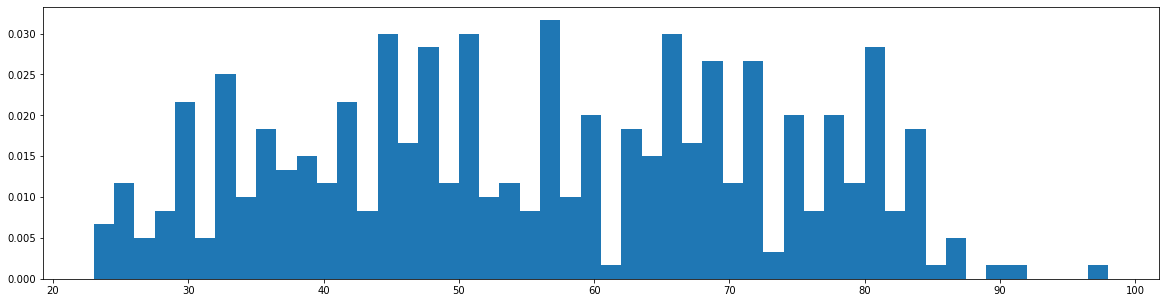

In [118]:
plt.hist(c2['Age'], density=True, bins=50)

In [119]:
# Age below 40
age = c2['Age']
bel_40 = []

for i in age:
    if i<=40:
        bel_40.append(1)
    else:
        bel_40.append(0)

c2['Age_bel_40'] = bel_40

In [120]:
# Age between 41 and 56
bel_41_56 = []

for i in age:
    if i>=41 and i<=56:
        bel_41_56.append(1)
    else:
        bel_41_56.append(0)

c2['Age_bet_41_56'] = bel_41_56

In [121]:
# Age above 56
above_56 = []

for i in age:
    if i>56:
        above_56.append(1)
    else:
        above_56.append(0)

c2['Age_above_56'] = above_56

In [122]:
c2.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance,Age_bel_40,Age_bet_41_56,Age_above_56
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333,1,0,0
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903,0,0,1
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580,0,0,1
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964,1,0,0
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331,0,0,1


In [123]:
#Construct model to observe whether credit card balance is significantly different for different age group. 
##Consider the age group over 56 as the baseline. 

In [124]:
result_3iv = smf.ols(formula='Balance ~ Age_bet_41_56 + Age_bel_40', data=c2).fit()    
print(result_3iv.summary())

                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     3.557
Date:                Tue, 13 Oct 2020   Prob (F-statistic):             0.0294
Time:                        23:18:33   Log-Likelihood:                -3015.8
No. Observations:                 400   AIC:                             6038.
Df Residuals:                     397   BIC:                             6050.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       483.0825     32.799     14.728